# Metropolis-Hastings implementation
## Pantheon + BAO + Cosmic cronometers
___

In [169]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92

# Best parameters
Om = 0.338 # Omega_matter
H0 = 73.03 # actual value of Hubble constant
M = -19.253 # SN absolute magnitude
h = H0/100 
Or = w_r/(h**2) # Omega_radiation
Ol = 1. - Or - Om # Omega_lambda

# We define a function in order to calculate H(a)
def H(z):
    #a = 1./(1.+z)
    return (H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))
def frac_H(z):
    #a = 1./(1.+z)
    return 1/(H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))

# And a function that calculates m_th depending if the galaxy is host or not
def host_select(row):
    if row['host']==0: #no host, we use our values of H(z)
        integral = sp.integrate.quad(frac_H,0.,row['z_hel'])[0] # element 1 is error
        m_th = M + 25. + 5.*np.log10(c*(1+row['z_hel'])*integral)
        # c must be in km/s in order to compensate H adimensionalisation
        return m_th
    if row['host']==1: #host, we use cepheids
        m_th = M + row['mu']
        return m_th
    
# A function that calculates H given z and aplies it to dataframe
def H_theo(row):
    return H(row['z'])

# A function that calculates the theorical values for BAO columns
def BAOs(row):
    idx = row.name # we obtain the index of the actual row
    if idx==0:
        # D_M(z_*), z_* = 1089.92
        integral = sp.integrate.quad(frac_H,0.,z_star)[0]
        return c*integral*10**(-3) # we will compare with a number in Gpc
    elif idx==1:
        # omega_m
        return Om*(h**2)
    elif idx==2:
        # D_V(z=0.122)
        integral = sp.integrate.quad(frac_H,0.,0.122)[0]
        return ((integral**2)*(c**3)*(0.122/H(0.122)))**(1/3)
    elif idx==3:
        # D_A(z=0.835)
        integral = sp.integrate.quad(frac_H,0.,0.835)[0]
        return (c/(1+0.835))*integral
    elif idx==4:
        # D_V(z=0.44)
        integral = sp.integrate.quad(frac_H,0.,0.44)[0]
        return ((integral**2)*(c**3)*(0.44/H(0.44)))**(1/3)
    elif idx==5:
        # D_V(z=0.60)
        integral = sp.integrate.quad(frac_H,0.,0.60)[0]
        return ((integral**2)*(c**3)*(0.60/H(0.60)))**(1/3)
    elif idx==6:
        # D_V(z=0.73)
        integral = sp.integrate.quad(frac_H,0.,0.73)[0]
        return ((integral**2)*(c**3)*(0.73/H(0.73)))**(1/3)
    elif idx==7:
        # H(z=0.32)
        return H(0.32)
    elif idx==8:
        # D_A(z=0.32)
        integral = sp.integrate.quad(frac_H,0.,0.32)[0]
        return (c/(1+0.32))*integral
    elif idx==9:
        # H(z=0.57)
        return H(0.57)
    elif idx==10:
        # D_A(z=0.57)
        integral = sp.integrate.quad(frac_H,0.,0.57)[0]
        return (c/(1+0.57))*integral
    elif idx==11:
        # D_A(z=1.48)
        integral = sp.integrate.quad(frac_H,0.,1.48)[0]
        return (c/(1+1.48))*integral
    elif idx==12:
        # H(z=1.48)
        return H(1.48)
    elif idx==13:
        # D_A(z=2.334)
        integral = sp.integrate.quad(frac_H,0.,2.334)[0]
        return (c/(1+2.334))*integral
    elif idx==14:
        # H(z=2.334)
        return H(2.334)

# Pantheon+ data
df_pant= pd.read_csv('data_Pantheon+.txt', sep=" ", header=None)
df_pant.columns = ["z", "z_hel", "m", "mu","host"]
# Pantheon+ cov matrix
cov_pant = pd.read_csv('cov_matrix_Pantheon+.txt', sep=" ", header=None)
inv_cov_pant = np.linalg.inv(cov_pant)

# BAO data
df_bao = pd.read_csv('Data_CMB_BAO.txt',header=None)
df_bao.columns = ["meas"]
# BAO cov matrix
cov_bao = pd.read_csv('cov_CMB_BAO.txt',sep='\t',header=None)
inv_cov_bao = np.linalg.inv(cov_bao)

# Cosmic cronometers data with diagonal cov matrix (sigmas)
df_cosmic = pd.read_csv('cosmic_crono.txt', sep='\t', header=None)
df_cosmic.columns= ['z','H','dH','non']
df_cosmic = data_cosmic[['z','H','dH']]
cov_cosmic = np.diag(df_cosmic['dH']**2)
inv_cov_cosmic = np.linalg.inv(cov_cosmic)

# Om,H0,M cov matrix obtained previously
mc_cov = pd.read_csv('cov_PBH.txt', sep='\t', header=0)  

# Example calculation of chi
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()

dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

df_bao['theo'] = df_bao.apply(BAOs, axis=1)
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

# chi squared for best parameters
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,len(df_bao),chi_bao)

# Parameter range values and standard deviation
Om_range = [0.28,0.32]
H0_range = [68.,72.]
M_range = [-19.2,-19.4]
sigma_Om = 0.01
sigma_H0 = 0.5
sigma_M = 0.1

# Random initial value of parameter vector
Om = np.random.uniform(Om_range[0],Om_range[1])
H0 = np.random.uniform(H0_range[0],H0_range[1])
M = np.random.uniform(M_range[0],M_range[1])
h = H0/100
Or = w_r/(h**2)
Ol = 1. - Or - Om
par_vec = [Om,H0,M] # we keep parameter values

# Calculating chi_pantheon
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()
dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

# Calculating chi_cosmics_parameters
df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
df_cosmic_p = df_cosmic.copy()
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

# Calculating chi_BAO
df_bao['theo'] = df_bao.apply(BAOs, axis=1)
df_bao_p = df_bao.copy()
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

chi = chi_pant + chi_cosmic + chi_bao

mcdata = pd.DataFrame([[Om,H0,M,chi]],columns=['Om','H0','M','chi'])  

for iter in tqdm(range(10000)):
    # We porpose a gaussian step
        # Using covariance
    mc_mu = np.array([Om,H0,M])
    Om, H0, M = np.random.multivariate_normal(mc_mu,mc_cov)
        # Independent
    #Om = np.random.normal(Om, sigma_Om)
    #H0 = np.random.normal(H0, sigma_H0)
    #M = np.random.normal(M, sigma_M)
    
    h = H0/100
    Or = w_r/(h**2)
    Ol = 1. - Or - Om
    
    df_pant_p['m_th'] = df_pant_p.apply(host_select, axis=1)
    
    dif_p = pd.DataFrame(df_pant_p['m']-df_pant_p['m_th'])
    prod1_p = inv_cov_pant.dot(dif_p)
    dif_p_trans = dif_p.transpose()
    chi_pant_p = float(dif_p_trans.dot(prod1_p)[0]) 
    
    df_cosmic_p['H_th'] = df_cosmic_p.apply(H_theo, axis=1)
    dif_p = pd.DataFrame(df_cosmic_p['H']-df_cosmic_p['H_th'])
    dif_trans_p = dif_p.transpose()
    prod1_p = inv_cov_cosmic.dot(dif_p)
    chi_cosmic_p = float(dif_trans_p.dot(prod1_p)[0])
    
    df_bao_p['theo'] = df_bao_p.apply(BAOs, axis=1)
    dif_p = pd.DataFrame(df_bao_p['meas']-df_bao_p['theo'])
    dif_trans_p = dif_p.transpose()
    prod1_p = inv_cov_bao.dot(dif_p)
    chi_bao_p = float(dif_trans_p.dot(prod1_p)[0])

    chi_p = chi_pant_p + chi_cosmic_p + chi_bao_p
    
    quot_L = np.exp(-0.5*(chi_p-chi))
    
    uni = np.random.uniform(0.,1.)
    
    if quot_L>=uni:
        df_pant= df_pant_p
        df_cosmic= df_cosmic_p
        df_bao = df_bao_p
        par_vec = [Om,H0,M]
        chi_pant = chi_pant_p
        chi_cosmic = chi_cosmic_p
        chi_bao = chi_bao_p
        chi = chi_p
        
    else:
        Om, H0, M = par_vec
        h = H0/100
        Or = w_r/(h**2)
        Ol = 1. - Or - Om
    
    mcdata.loc[len(mcdata)]={'Om':Om,
                             'H0':H0,
                             'M':M,
                             'chi':chi} 
    
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,len(df_bao),chi_bao)
#mcdata.to_csv('mc80000PBH.txt', sep='\t', index=False)

1657 1486.6489731635627 48 231.36911784615322 15 6888.1480511817745


100%|█████████████████████████████████████| 10000/10000 [23:38<00:00,  7.05it/s]

1657 1518.385415754228 48 32.73975018453917 15 14.243836073556647


In [178]:
#mcdata.to_csv('mc10000PBH.txt', sep='\t', index=False)
#cov_PBH = mcdata[['Om','H0','M']].cov()
#cov_PBH.to_csv('cov_PBH.txt', sep='\t', index=False)

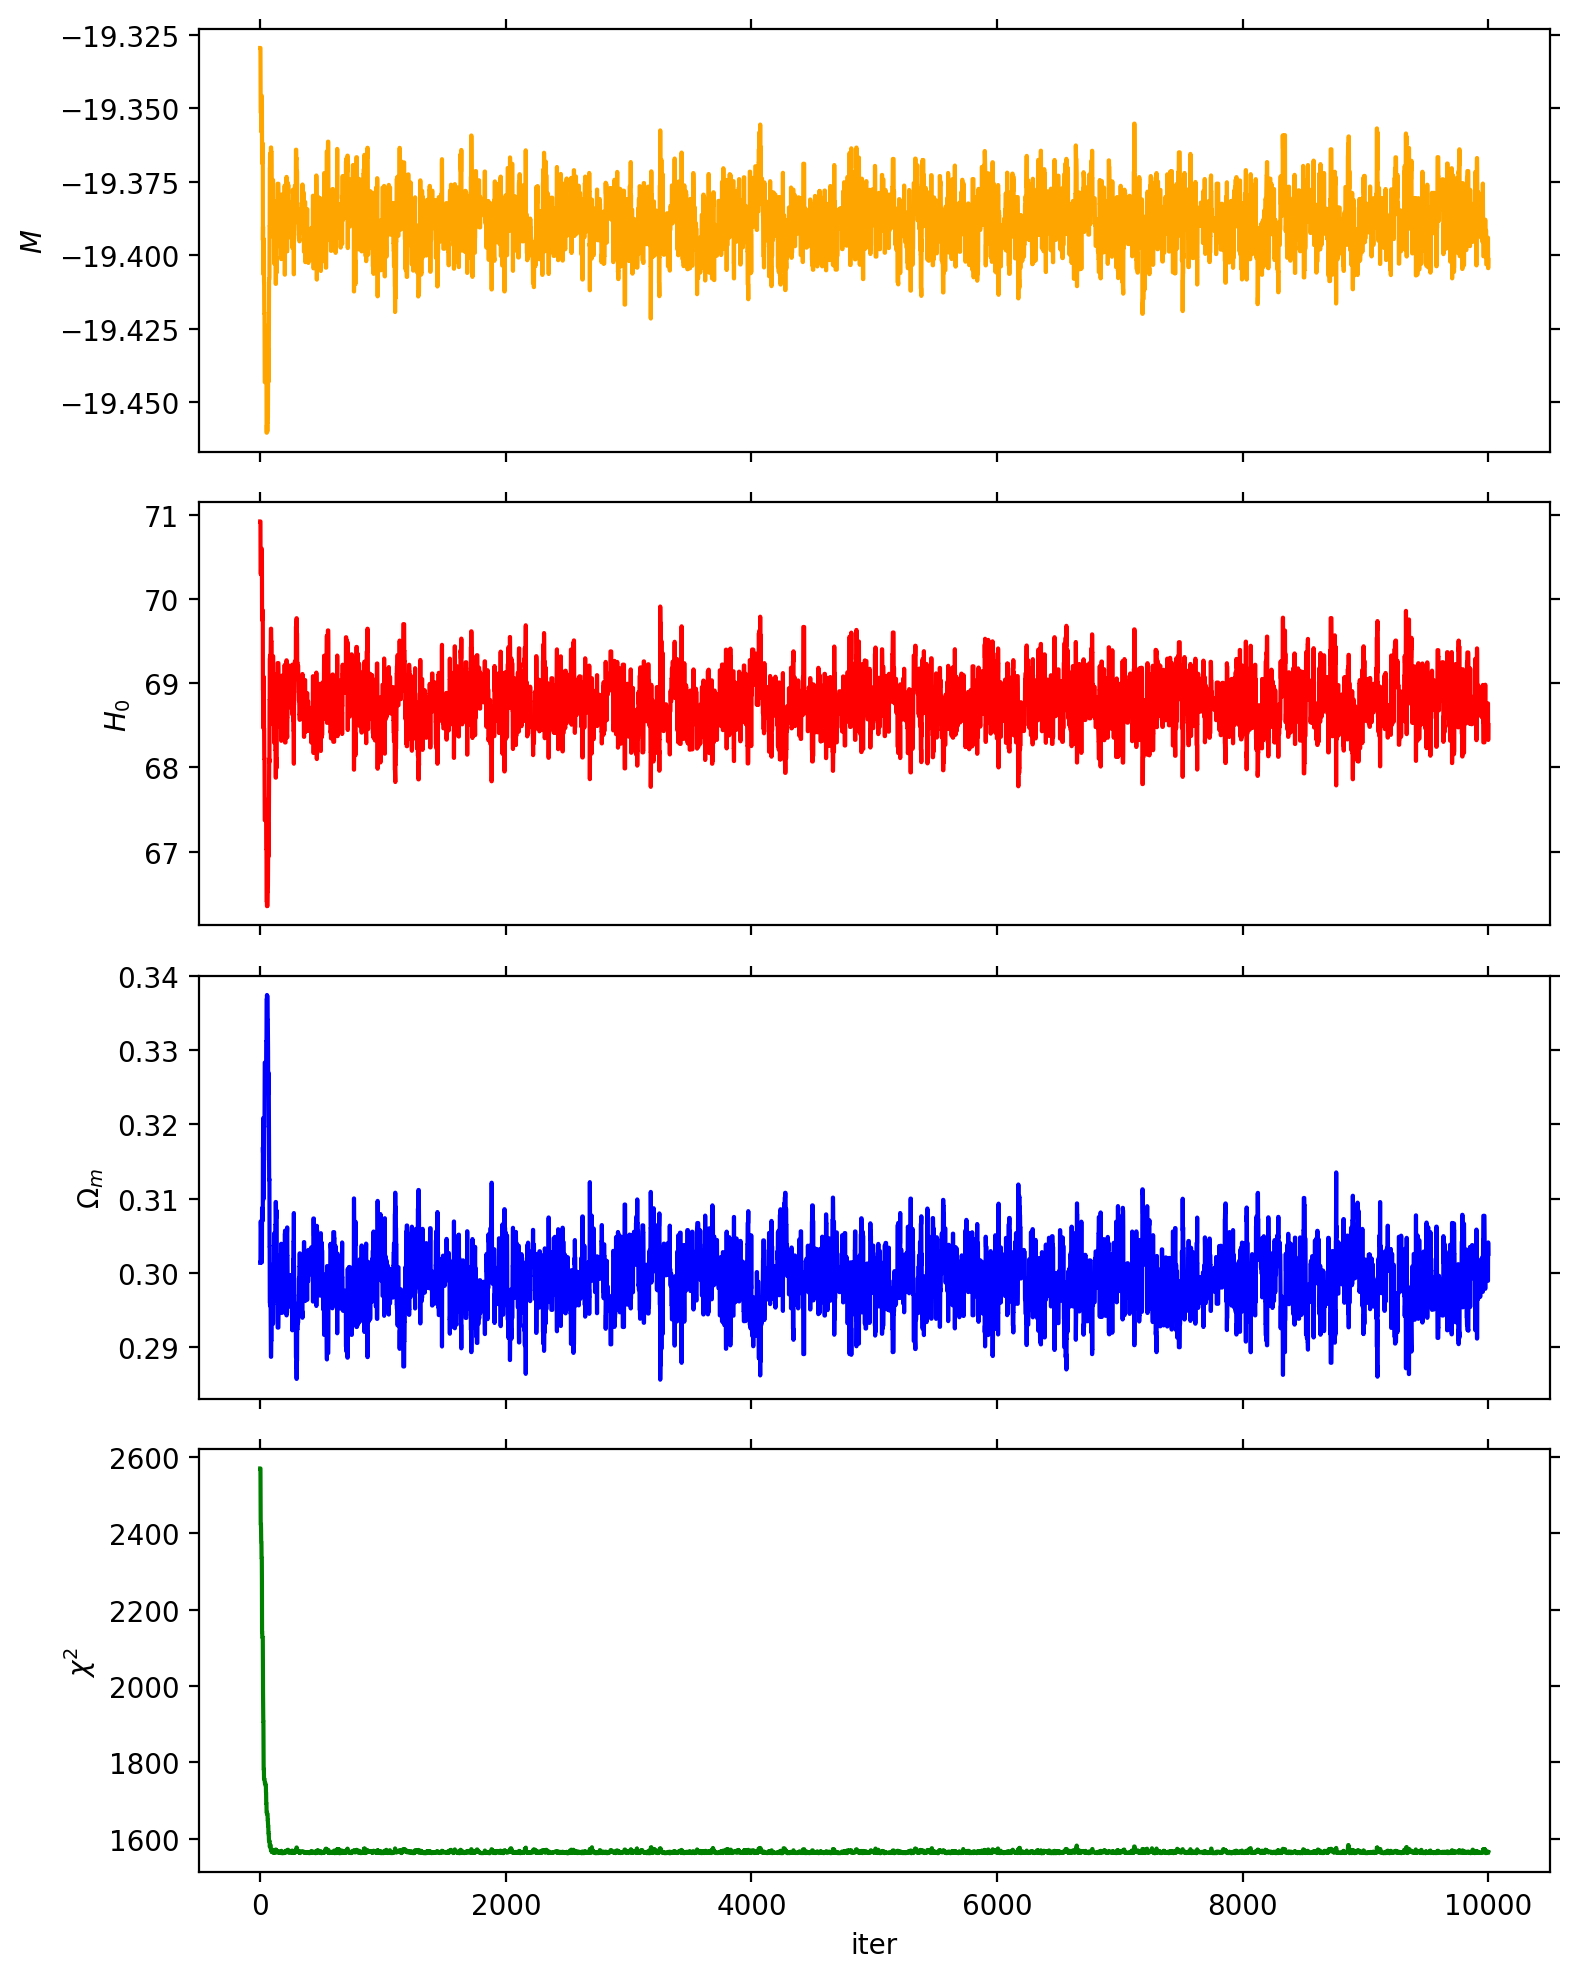

In [170]:
fig, ax = plt.subplots(nrows=4,ncols=1,sharex=True)
fig.set_size_inches(8, 10)

ax[0].plot(mcdata['M'], 'orange',label='$M$')
#ax[0].set_xlabel("iter")
ax[0].set_ylabel("$M$")
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].plot(mcdata['H0'], 'red',label='$H_0$')
#ax[1].set_xlabel("iter")
ax[1].set_ylabel("$H_0$")
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

ax[2].plot(mcdata['Om'], 'blue',label='$\Omega_m$')
ax[2].set_ylabel("$\Omega_m$")
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_ticks_position('both')

ax[3].plot(mcdata['chi'], 'green',label='$chi$')
ax[3].set_xlabel("iter")
ax[3].set_ylabel("$\chi^2$")
#ax[3].set_yscale('log')
ax[3].yaxis.set_ticks_position('both')
ax[3].xaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

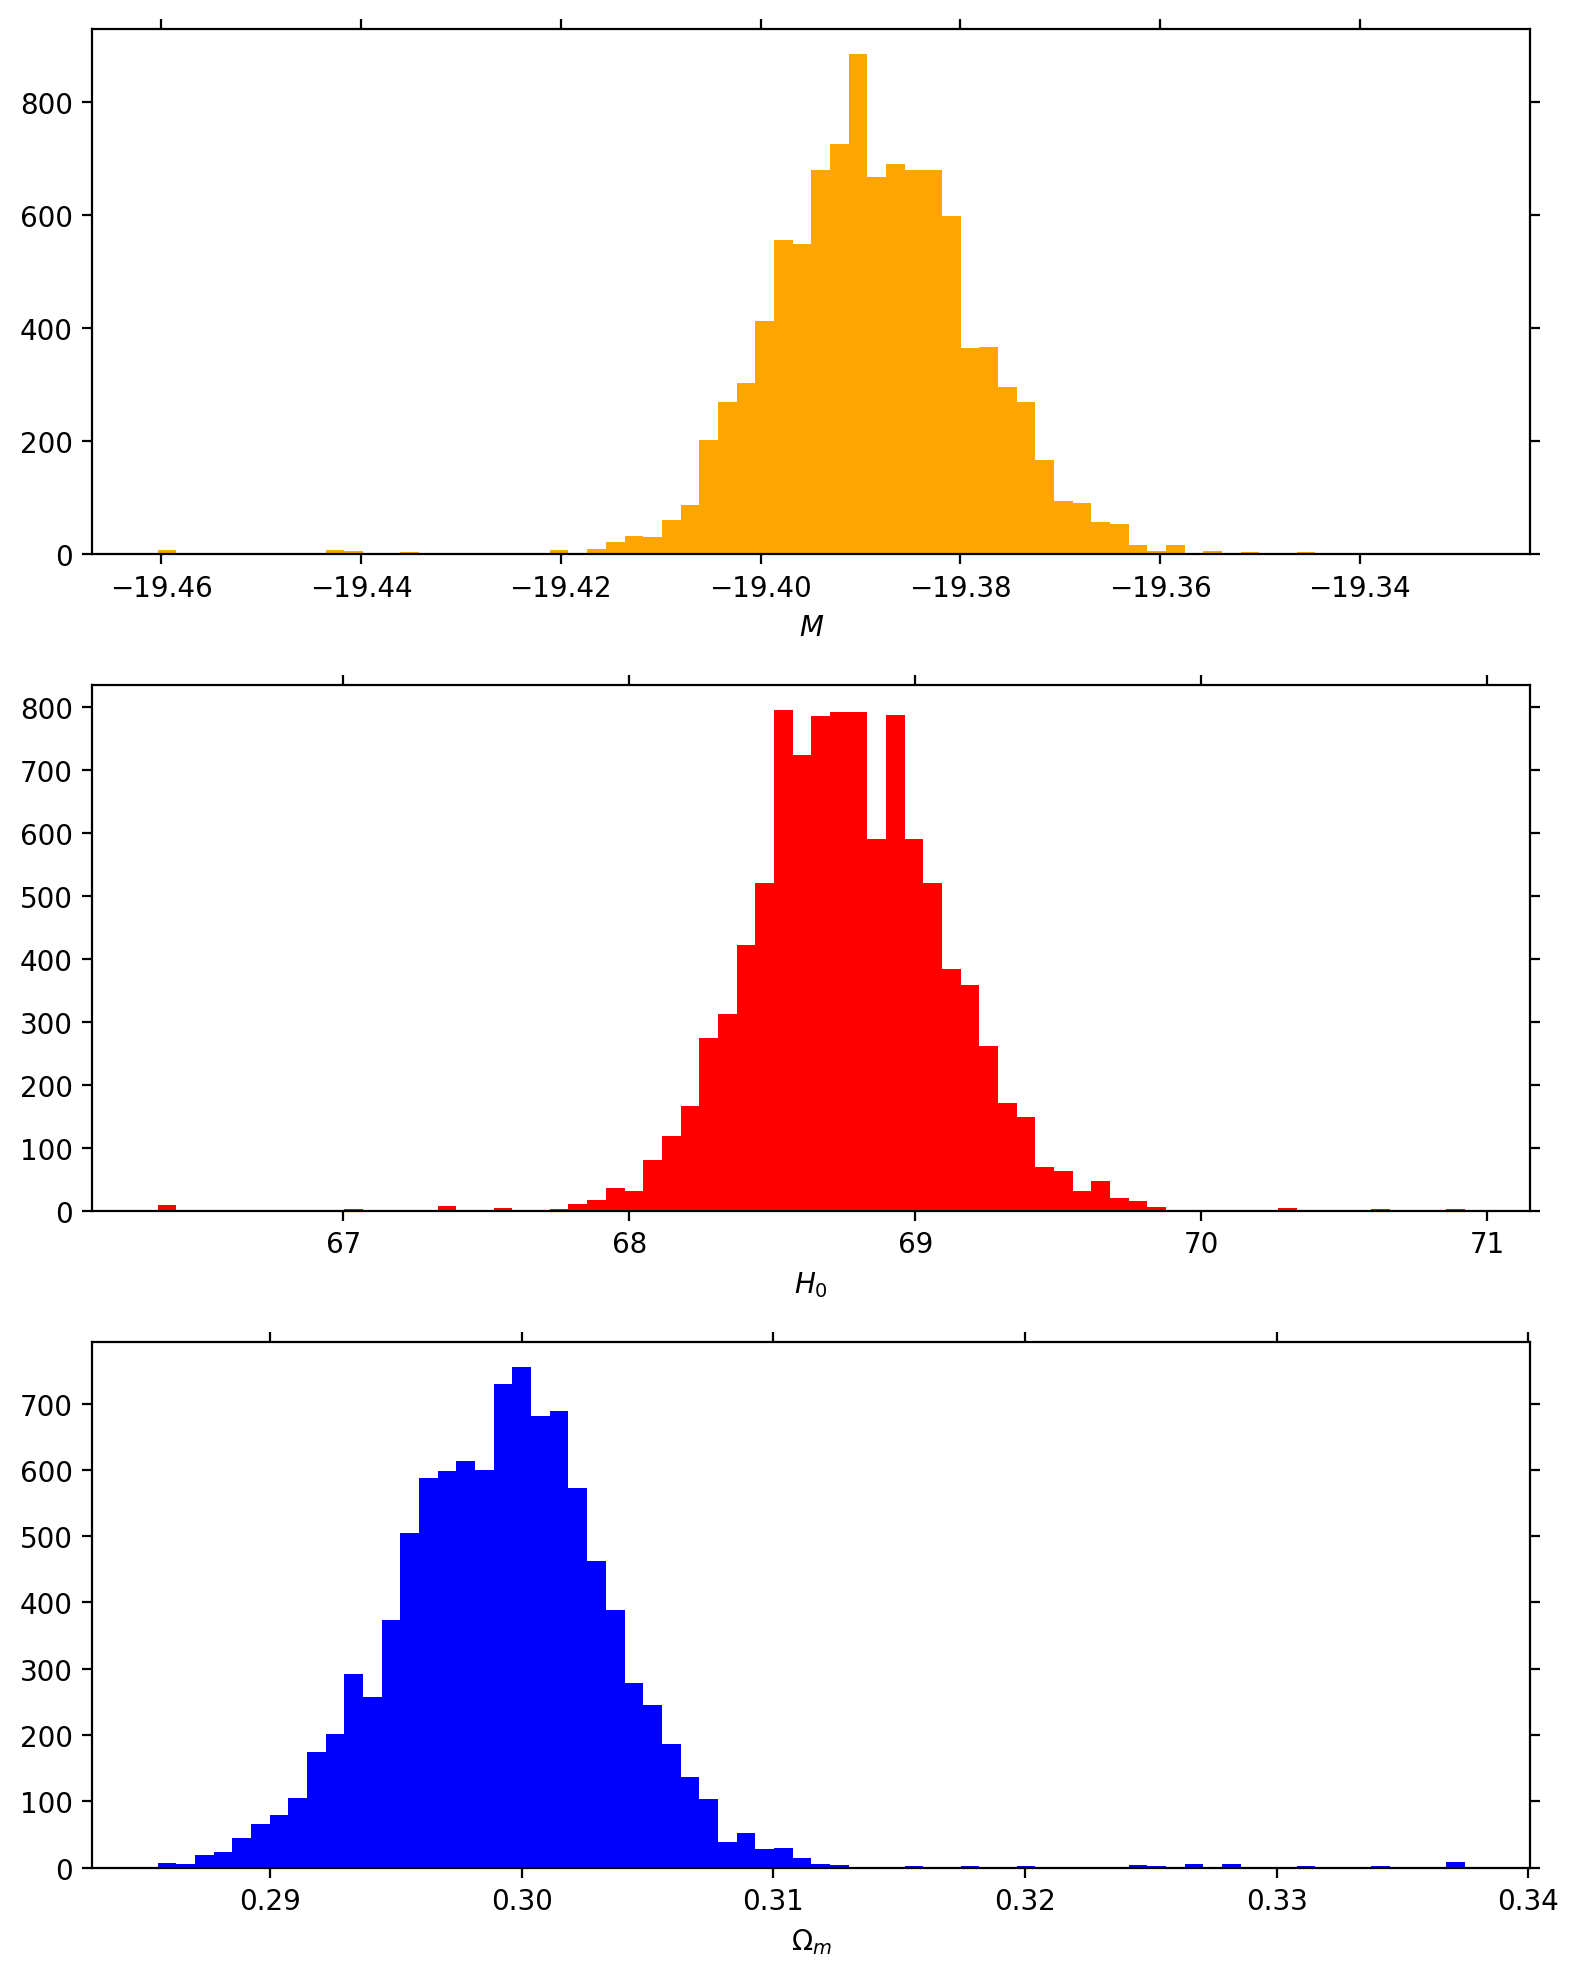

In [171]:
fig, ax = plt.subplots(nrows=3,ncols=1,sharex=False)
fig.set_size_inches(8, 10)

nbins = 70

ax[0].hist(mcdata['M'],bins = nbins,color='orange')
ax[0].set_xlabel("$M$")
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].hist(mcdata['H0'],bins = nbins,color='red')
ax[1].set_xlabel("$H_0$")
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

ax[2].hist(mcdata['Om'],bins = nbins,color='blue')
ax[2].set_xlabel("$\Omega_m$")
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

In [172]:
# Find the upper and lower limit under minimum 68% of confidence level
def error(boxin,hist):
    
    box_len = boxin[1]-boxin[0]
    boxes = np.zeros(len(hist))
    for idx in range(len(boxin)-1):
        boxes[idx] = 0.5*(boxin[idx+1]+boxin[idx])
    surf = (box_len*hist).sum()
        
    count = 0
    P = 0.99*hist.max()
    sigma = 0
    
    while sigma <0.683:
        count = count+1
        if count == 10000:
            break
        for idx in range(1,len(hist)):
            if hist[idx]>P:
                xa = boxes[idx-1]
                break
        for idx in range(1,len(hist)):
            if hist[-idx]>P:
                xb = boxes[-idx-1]
                break
        if xa<xb:
            surf_sig = (box_len*(hist*(boxes>xa)*(boxes<xb))).sum()
        else:
            surf_sig = (box_len*(hist*(boxes<xa)*(boxes>xb))).sum()
        sigma = surf_sig/surf
        P = 0.99*P
    return xa, xb, sigma

In [173]:
M_count, M_pos = np.histogram(mcdata['M'],bins = nbins)
M_best = M_pos[int(np.where(M_count == np.max(M_count))[0])] # most obtained value

H0_count, H0_pos = np.histogram(mcdata['H0'],bins = nbins)
H0_best = H0_pos[int(np.where(H0_count == np.max(H0_count))[0])] # most obtained value

Om_count, Om_pos = np.histogram(mcdata['Om'],bins = nbins)
Om_best = Om_pos[int(np.where(Om_count == np.max(Om_count))[0])] # most obtained value

M1, M2, M_sigma = error(M_pos, M_count)
print('Best M:', M_best, '+',M2-M_best, '-', M_best-M1, ', confidence rate:',M_sigma,'\n')

Om1, Om2, Om_sigma = error(Om_pos, Om_count)
print('Best Omegam:', Om_best, '+',Om2-Om_best, '-', Om_best-Om1, ', confidence rate:',Om_sigma,'\n')

H01, H02, H0_sigma = error(H0_pos, H0_count)
print('Best H0:', H0_best, '+',H02-H0_best, '-', H0_best-H01, ', confidence rate:',H0_sigma,'\n')

h_best = H0_best/100 
Or_best = w_r/(h_best**2) # Omega_radiation
Ol_best = 1. - Or_best - Om_best # Omega_lambda
print('Best Omegalambda:', Ol_best)

Best M: -19.39118004466105 + 0.012153258584611137 - 0.010283526494674788 , confidence rate: 0.712028797120288 

Best Omegam: 0.2996398627062801 + 0.003338408720804431 - 0.007047751743920416 , confidence rate: 0.7253274672532746 

Best H0: 68.50553546577069 + 0.6202532516579424 - 0.16322453990997587 , confidence rate: 0.7315268473152686 

Best Omegalambda: 0.7003075271171528


## GetDist

In [5]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import numpy as np
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.8, Matplotlib version: 3.7.1


In [6]:
PANT_mcdata = pd.read_csv('mc20000dep.txt', sep='\t', header=0)
PANT_BAO_COSMIC_mcdata = pd.read_csv('mc10000PBH.txt', sep='\t', header=0)

ndim=3
names = ['M','H0','Omega_m']
labels = ['M','H_0','\Omega_m']
samples1 = MCSamples(samples=[np.array(PANT_mcdata['M']),
                               np.array(PANT_mcdata['H0']),
                               np.array(PANT_mcdata['Om'])],
                      names = names, labels = labels)
samples2 = MCSamples(samples=[np.array(PANT_BAO_COSMIC_mcdata['M']),
                               np.array(PANT_BAO_COSMIC_mcdata['H0']),
                               np.array(PANT_BAO_COSMIC_mcdata['Om'])],
                      names = names, labels = labels)

Removed no burn in
Removed no burn in


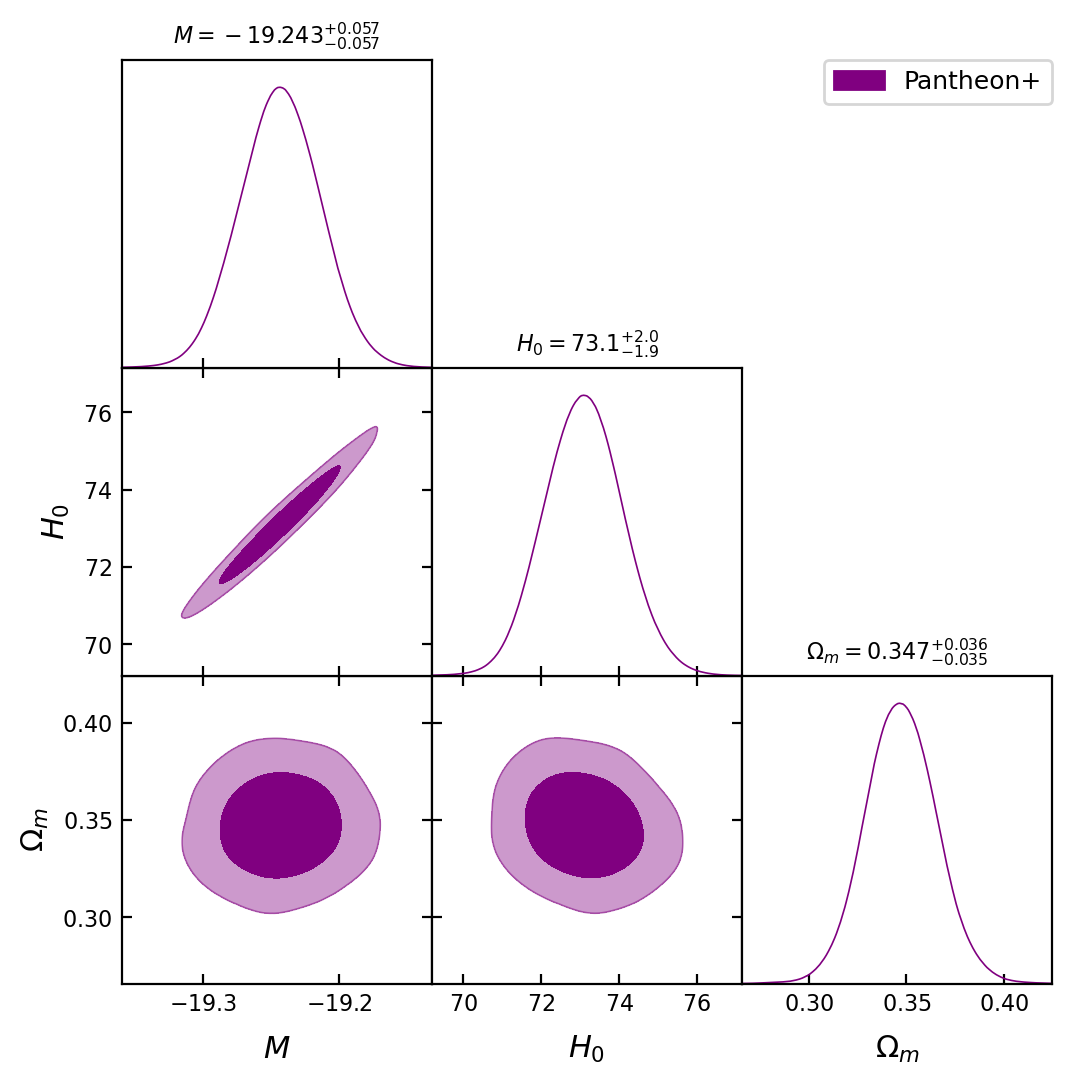

In [7]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1], filled=True,
                contour_colors=['purple'],
                title_limit=2, legend_labels=['Pantheon+'])

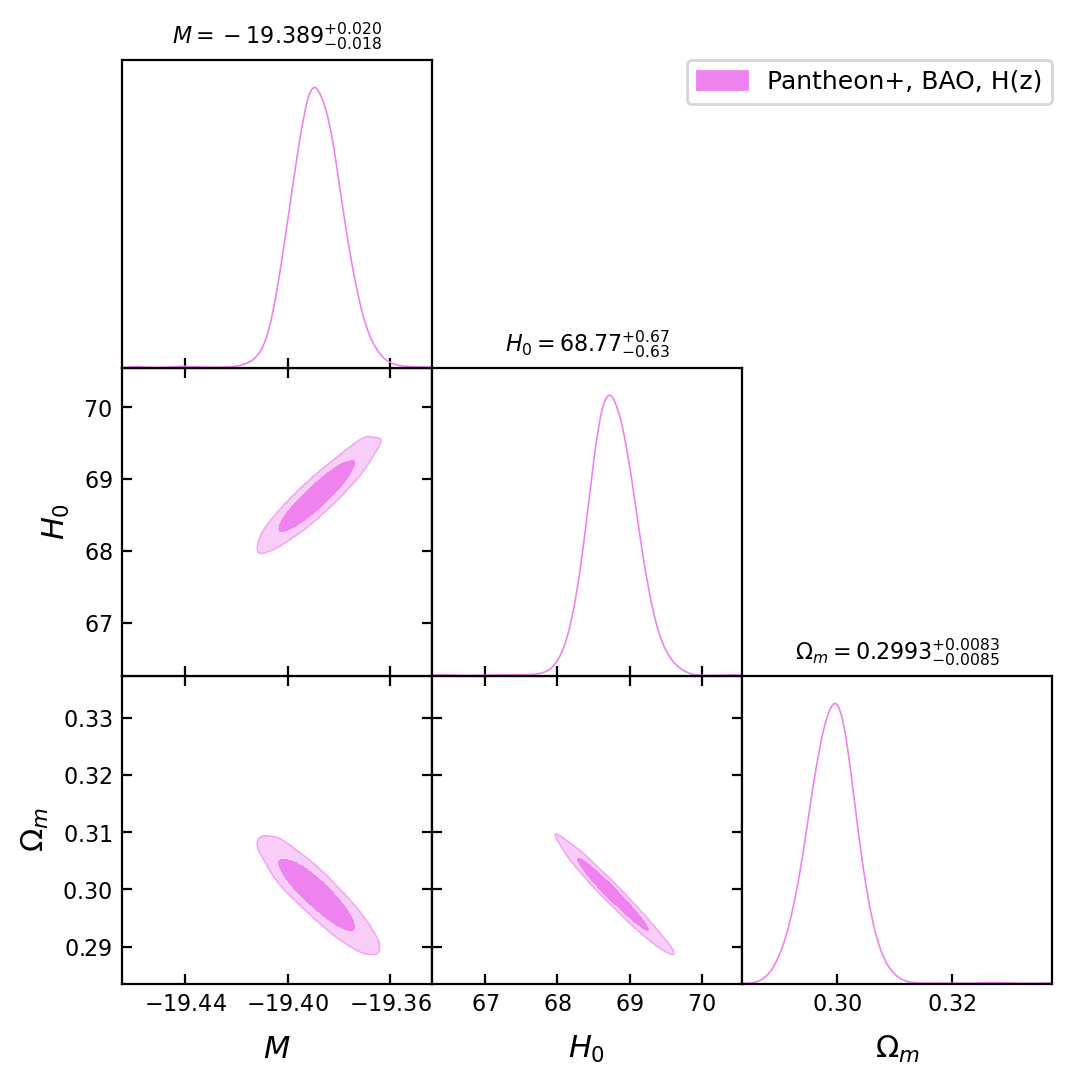

In [8]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True,
                contour_colors=['violet'],
                title_limit=2, legend_labels=['Pantheon+, BAO, H(z)'])

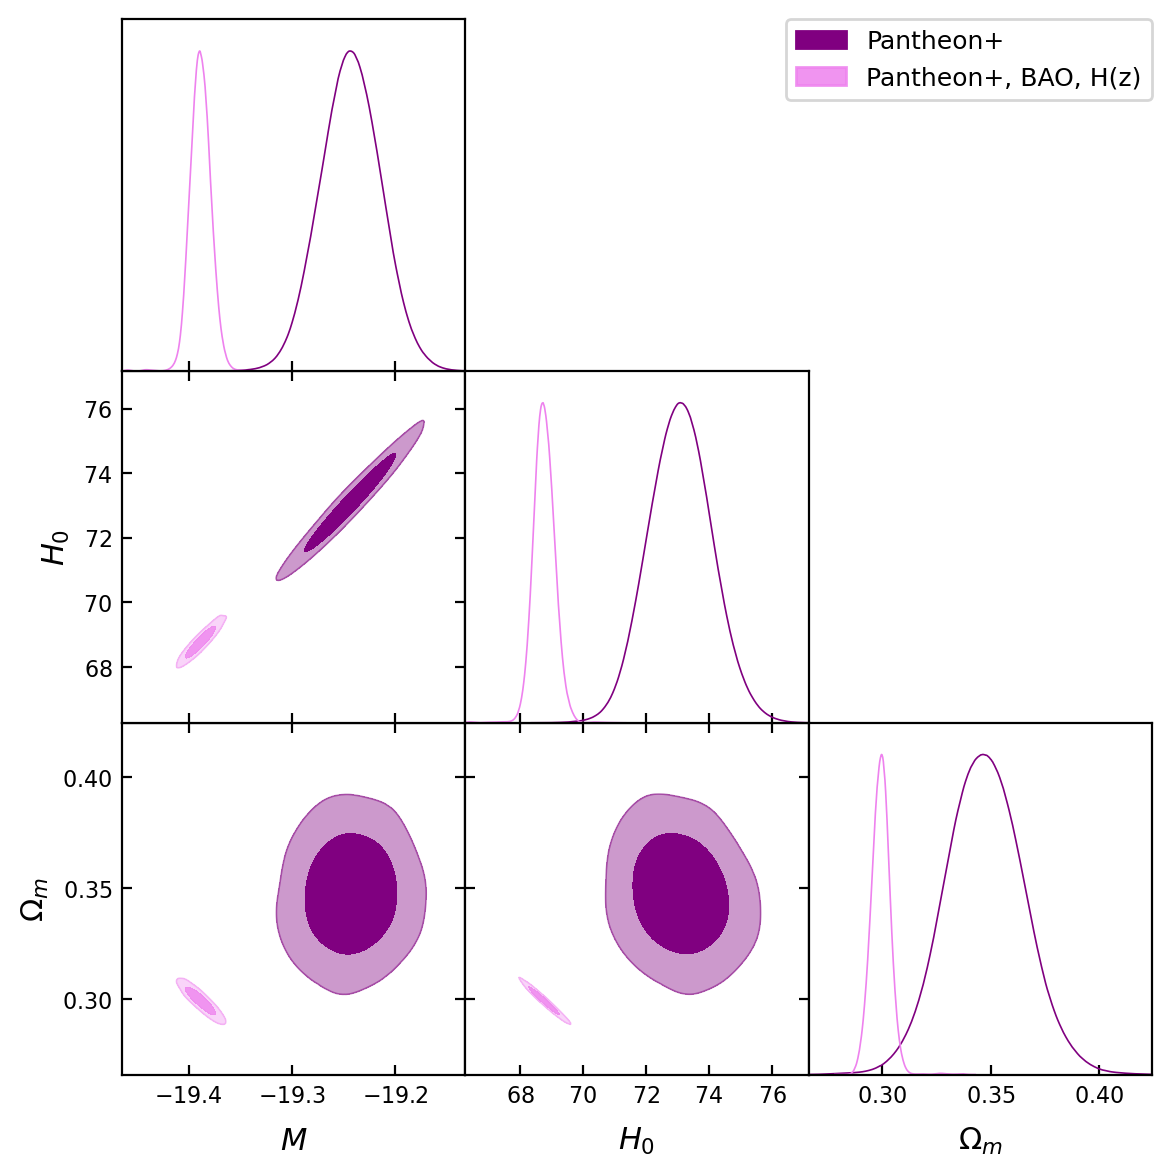

In [9]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1,samples2], filled=True,
                contour_colors=['purple','violet'],
                title_limit=0, legend_labels=['Pantheon+','Pantheon+, BAO, H(z)'])

### For individual cases of $\chi^2$ calculation

In [98]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92


# Parameters
H0 = 68.45259414181695
Om = 0.141782/pow(H0/100,2) 
M = -19.396122
h = H0/100 
Or = w_r/(h**2) 
Ol = 1. - Or - Om 
alpha = 0.
tau = 0.

# We define a function in order to calculate H(a)
def H(z):
    #a = 1./(1.+z)
    return (H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))
def frac_H(z):
    #a = 1./(1.+z)
    return 1/(H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))

# And a function that calculates m_th depending if the galaxy is host or not
def host_select(row):
    if row['host']==0: #no host, we use our values of H(z)
        integral = sp.integrate.quad(frac_H,0.,row['z_hel'])[0] # element 1 is error
        m_th = M + 25. + 5.*np.log10(c*(1+row['z_hel'])*integral)
        # c must be in km/s in order to compensate H adimensionalisation
        return m_th
    if row['host']==1: #host, we use cepheids
        m_th = M + row['mu']
        return m_th
    
# A function that calculates H given z and aplies it to dataframe
def H_theo(row):
    return H(row['z'])

# A function that calculates the theorical values for BAO columns
def BAOs(row):
    idx = row.name # we obtain the index of the actual row
    if idx==0:
        # D_M(z_*), z_* = 1089.92
        integral = sp.integrate.quad(frac_H,0.,z_star)[0]
        return c*integral*10**(-3) # we will compare with a number in Gpc
    elif idx==1:
        # omega_m
        return Om*(h**2)
    elif idx==2:
        # D_V(z=0.122)
        integral = sp.integrate.quad(frac_H,0.,0.122)[0]
        return ((integral**2)*(c**3)*(0.122/H(0.122)))**(1/3)
    elif idx==3:
        # D_A(z=0.835)
        integral = sp.integrate.quad(frac_H,0.,0.835)[0]
        return (c/(1+0.835))*integral
    elif idx==4:
        # D_V(z=0.44)
        integral = sp.integrate.quad(frac_H,0.,0.44)[0]
        return ((integral**2)*(c**3)*(0.44/H(0.44)))**(1/3)
    elif idx==5:
        # D_V(z=0.60)
        integral = sp.integrate.quad(frac_H,0.,0.60)[0]
        return ((integral**2)*(c**3)*(0.60/H(0.60)))**(1/3)
    elif idx==6:
        # D_V(z=0.73)
        integral = sp.integrate.quad(frac_H,0.,0.73)[0]
        return ((integral**2)*(c**3)*(0.73/H(0.73)))**(1/3)
    elif idx==7:
        # H(z=0.32)
        return H(0.32)
    elif idx==8:
        # D_A(z=0.32)
        integral = sp.integrate.quad(frac_H,0.,0.32)[0]
        return (c/(1+0.32))*integral
    elif idx==9:
        # H(z=0.57)
        return H(0.57)
    elif idx==10:
        # D_A(z=0.57)
        integral = sp.integrate.quad(frac_H,0.,0.57)[0]
        return (c/(1+0.57))*integral
    elif idx==11:
        # D_A(z=1.48)
        integral = sp.integrate.quad(frac_H,0.,1.48)[0]
        return (c/(1+1.48))*integral
    elif idx==12:
        # H(z=1.48)
        return H(1.48)
    elif idx==13:
        # D_A(z=2.334)
        integral = sp.integrate.quad(frac_H,0.,2.334)[0]
        return (c/(1+2.334))*integral
    elif idx==14:
        # H(z=2.334)
        return H(2.334)

# Pantheon+ data
df_pant= pd.read_csv('data_Pantheon+.txt', sep=" ", header=None)
df_pant.columns = ["z", "z_hel", "m", "mu","host"]
# Pantheon+ cov matrix
cov_pant = pd.read_csv('cov_matrix_Pantheon+.txt', sep=" ", header=None)
inv_cov_pant = np.linalg.inv(cov_pant)

# BAO data
df_bao = pd.read_csv('Data_CMB_BAO.txt',header=None)
df_bao.columns = ["meas"]
# BAO cov matrix
cov_bao = pd.read_csv('cov_CMB_BAO.txt',sep='\t',header=None)
inv_cov_bao = np.linalg.inv(cov_bao)

# Cosmic cronometers data with diagonal cov matrix (sigmas)
df_cosmic = pd.read_csv('cosmic_crono.txt', sep='\t', header=None)
df_cosmic.columns= ['z','H','dH','non']
df_cosmic = df_cosmic[['z','H','dH']]
cov_cosmic = np.diag(df_cosmic['dH']**2)
inv_cov_cosmic = np.linalg.inv(cov_cosmic)

# alpha_em constraints
df_alpha = pd.read_csv('alpha_data.txt', sep='\t', header=0)
cov_alpha = np.diag(df_alpha['err']**2)
inv_cov_alpha = np.linalg.inv(cov_alpha)

# Om,H0,M cov matrix obtained previously
mc_cov = pd.read_csv('cov_PBH.txt', sep='\t', header=0)  

# Example calculation of chi
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()
dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

df_bao['theo'] = df_bao.apply(BAOs, axis=1)
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

df_alpha['da/a_theo'] = np.zeros(len(df_alpha))
dif = pd.DataFrame(df_alpha['da/a']-df_alpha['da/a_theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_alpha.dot(dif)
chi_alpha = float(dif_trans.dot(prod1)[0])

# chi squared
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,
      len(df_bao),chi_bao, len(df_alpha), chi_alpha)
print(len(df_pant)+len(df_cosmic)+len(df_bao)+len(df_alpha),
      chi_pant+chi_cosmic+chi_bao+chi_alpha)

chi_lambda = chi_pant+chi_cosmic+chi_bao+chi_alpha
chi_lambda_sensealpha = chi_pant+chi_cosmic+chi_bao

1657 1516.651478358613 48 32.64635869746585 15 14.417059563519441 28 17.26255885236078
1748 1580.977455471959


In [533]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92
alpha_em = 0.0072973525693

M = -19.396122
w_m = 0.141782
k = 39202.357990
alpha = 0.000052
tau = -0.000009

# Obtaining scale parameter vector
var_a = []
step_a = []
a0 = pow(10.,-6)
var_a.append(a0)
while a0<=1.:
    a1 = a0*(1. + 1./10000.)
    var_a.append(a1)
    step_a.append(a0/10000.)
    a0 = a1
# Only values that fulfill a<1.
var_a = np.array(var_a)
step_a = np.array(step_a)
var_z = 1./var_a -1. # redshift list
step_z = 1./step_a -1.

# Solving the differential equation sistem
def fun(a,y):
    H = np.sqrt(np.abs((k*pow(y[0],-alpha)+1.2*pow(10.,5)*
                        (w_m*pow(a,-3)+w_r*pow(a,-4)))/(12-pow(a*y[1],2))))
    dH = -(3./(2*a*H))*(pow(a*H*y[1],2)/6. + pow(10.,4)*
                        (w_m*pow(a,-3)+(4./3.)*w_r*pow(a,-4)))
    f = np.zeros(2,dtype=np.float64)
    f[0]=y[1]
    f[1]=-(4./a + dH/H)*y[1] + (alpha*0.5*k*pow(y[0],-(alpha+1)))/pow(a*H,2)
    return f

# Initial values
a_ini = pow(10,-6)
a_fin = var_a[-1]

phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4),
          1./(alpha+2.))
dphi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4.-alpha-2.),
          1./(alpha+2.))*4./(alpha+2.)

# Scipy solver
sol = solve_ivp(fun, [a_ini, a_fin], [phi, dphi], t_eval=var_a)

# Some usefull lists (values for all evolution)
phis = np.array(sol.y.T[:,0]) # scalar field
dphis = np.array(sol.y.T[:,1]) # scalar field proper time derivative
Mpl = 1.22*10**19 # Planck mass
V = (1/2)*k*(phis**(-alpha)) # potential for every a value
Hs = np.sqrt(np.abs((k*pow(phis,-alpha)+1.2*pow(10.,5)*
                     (w_m*pow(var_a,-3)+w_r*pow(var_a,-4)))/(12-pow(var_a*dphis,2)))) # H(a) for every a

In [426]:
var_z.min(), var_z.max()

(1.3219161323352324e-06, 999999.0)

In [545]:
distances = pd.DataFrame(columns=['z'])
distances['z'] = var_z[:-1]

In [547]:
def frac_H(z):
    dist = np.abs(var_z-z)
    return 1./Hs[np.nonzero(dist == dist.min())[0][0]]

def integrate_frac_H(z_lim):
    idx = ((var_z<z_lim)==0).sum()
    z_int = var_z[idx:]
    frac_H_int = 1./(Hs[idx:])
    integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
    return np.abs(integral.sum())

def distance_phi(row):  
    integral = integrate_frac_H(row['z'])
    dist = c*(1+row['z'])*integral
    # c must be in km/s in order to compensate H adimensionalisation
    return dist

distances['dist_phi'] = distances.apply(distance_phi, axis=1)

In [548]:
def frac_H(z):
    #a = 1./(1.+z)
    return 1/(H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))

def distance(row):  
    integral = sp.integrate.quad(frac_H,0.,row['z'])[0] # element 1 is error
    dist = c*(1+row['z'])*integral
    # c must be in km/s in order to compensate H adimensionalisation
    return dist

distances['dist_lamb'] = distances.apply(distance, axis=1)

In [549]:
distances

,z,dist_phi,dist_lamb
0,9.999990e+05,1.421570e+10,1.421573e+10
1,9.998990e+05,1.421428e+10,1.421431e+10
2,9.997990e+05,1.421286e+10,1.421288e+10
3,9.996991e+05,1.421144e+10,1.421146e+10
4,9.995991e+05,1.421002e+10,1.421004e+10
...,...,...,...
232501,4.604897e-06,1.751835e-02,2.016751e-02
232502,3.604894e-06,1.313875e-02,1.578790e-02
232503,2.604891e-06,8.759153e-03,1.140831e-02
232504,1.604889e-06,4.379571e-03,7.028724e-03


In [448]:
np.array(distances['dist_phi']-distances['dist_lamb'])[-1]

-0.4437810622478695

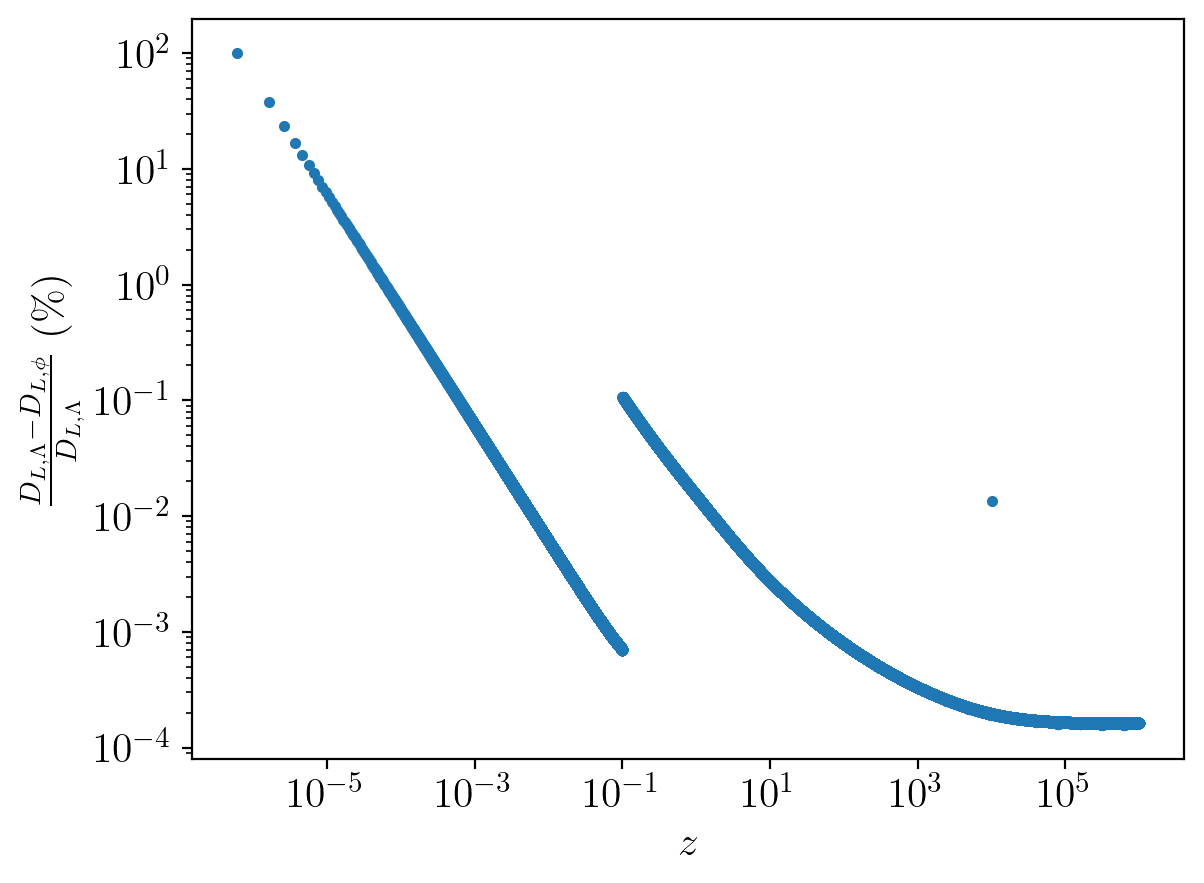

In [550]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern'})
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(var_z[:-1],100*abs(distances['dist_phi']-distances['dist_lamb'])/distances['dist_lamb'],
        '.')
plt.semilogx()
#plt.loglog()
plt.semilogy()
plt.xlabel('$z$')
plt.ylabel('$\\frac{D_{L,\Lambda} - D_{L,\phi}}{D_{L,\Lambda}}$ (\%)')
plt.show()

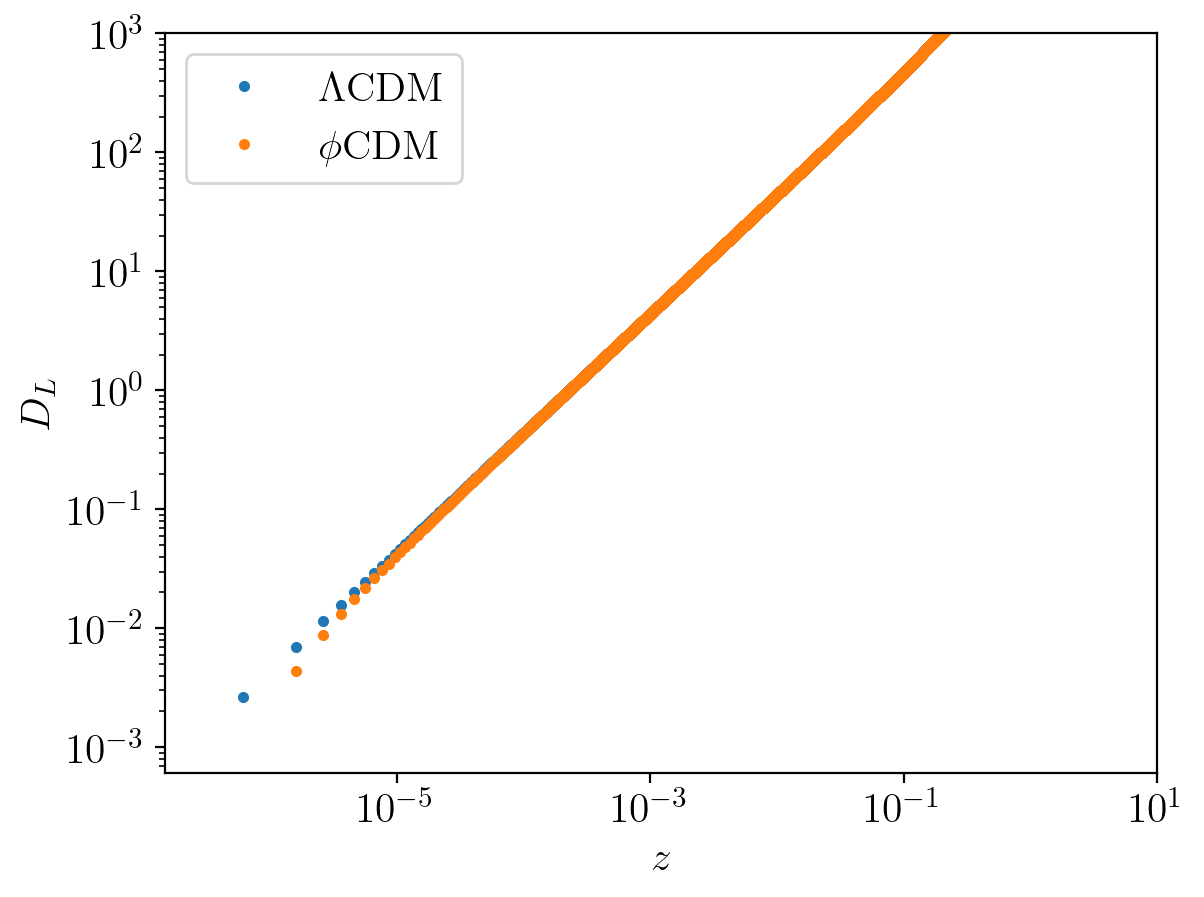

In [551]:
plt.plot(var_z[:-1], distances['dist_lamb'],'.',label='$\\Lambda$CDM')
plt.plot(var_z[:-1], distances['dist_phi'],'.', label='$\phi$CDM')
plt.loglog()
plt.xlabel('$z$')
plt.ylabel('$D_L$')
plt.ylim(0,1000)
plt.xlim(0,10)
plt.legend()
plt.show()

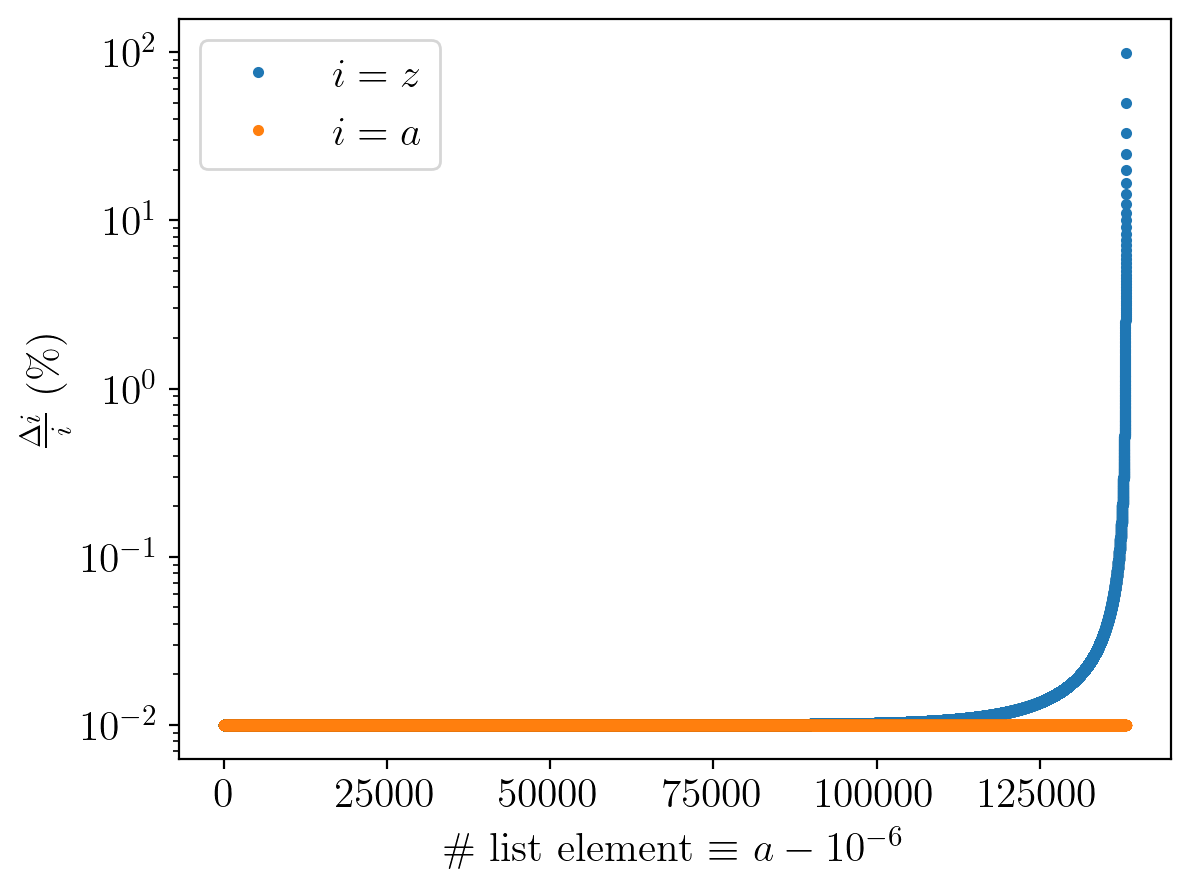

In [396]:
plt.plot(100*abs(var_z[1:]-var_z[:-1])/var_z[:-1],'.',label='$i=z$')
plt.plot(100*abs(var_a[1:]-var_a[:-1])/var_a[:-1],'.',label='$i=a$')
plt.semilogy()
#plt.loglog()
plt.xlabel('$\#$ list element $\equiv$ $a-10^{-6}$')
plt.legend()
plt.ylabel('$\\frac{\Delta i}{i}$ (\%)')
plt.show()

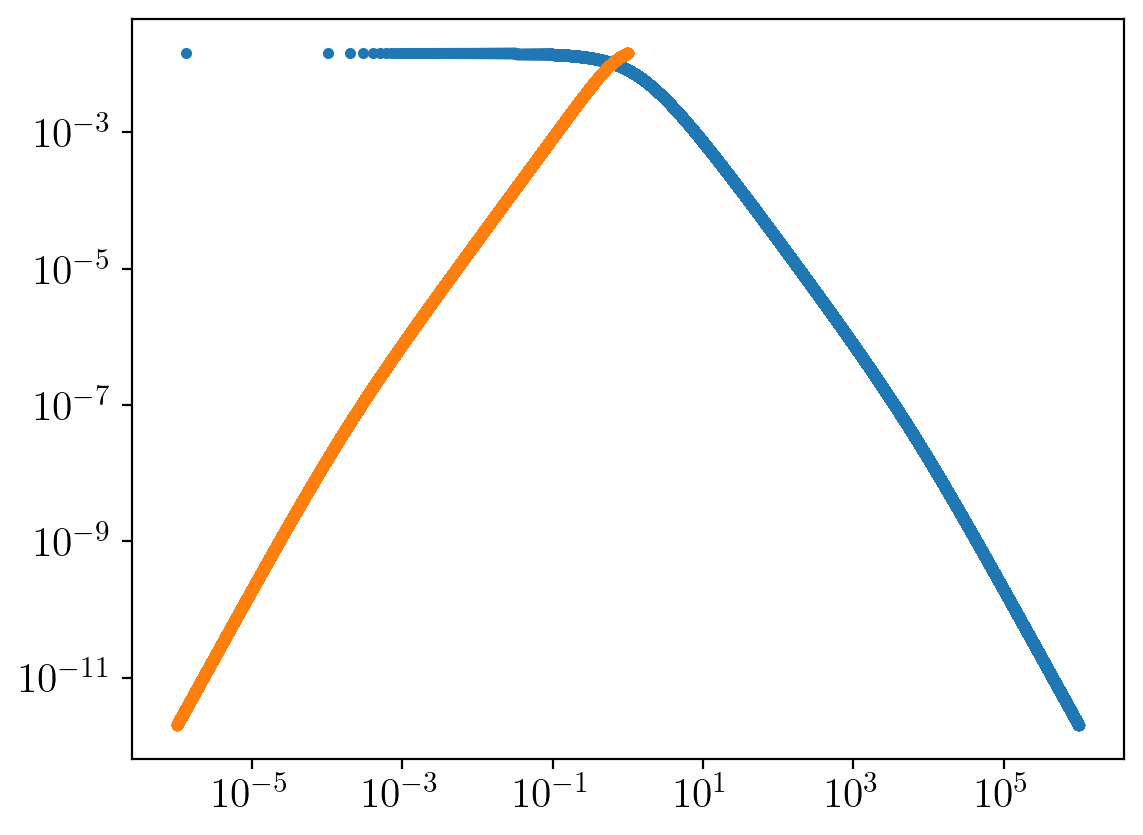

In [510]:
plt.plot(var_z,1./Hs,'.')
plt.plot(var_a,1./Hs,'.')
plt.loglog()
#plt.xlim(0,pow(10,-3))
#plt.ylim(0.01,0.02)
#plt.ylim(0,pow(10,3))
plt.show()

In [ ]:
plt.plot()

In [423]:
np.abs(sp.integrate.quad(frac_H_Lambda,0.,var_z[-1])[0])

1.931140451657751e-08

In [281]:
def frac_H2(z):
    idx = ((var_z<z)==0).sum()
    return 1./Hs[idx]

def frac_H(z):
    dist = np.abs(var_z-z)
    return 1./Hs[np.nonzero(dist == dist.min())[0][0]]

In [283]:
frac_H2(1000000.), frac_H(1000000.)

(2.0067628682870697e-12, 2.0067628682870697e-12)

In [542]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92
alpha_em = 0.0072973525693

M = -19.396122
w_m = 0.141782
k = 39202.357990
alpha = 0.000052
tau = -0.000009

# Obtaining scale parameter vector
var_a = []
step_a = []
a0 = pow(10.,-6)
var_a.append(a0)
while a0<=1.:
    z = 1./a0 -1.
    if z>pow(10,-1):
        a1 = a0*(1. + 1./10000.)
        var_a.append(a1)
        step_a.append(a0/10000.)
        a0 = a1
    else:
        a1 = a0*(1. + 1./1000000.)
        var_a.append(a1)
        step_a.append(a0/1000000.)
        a0 = a1
# Only values that fulfill a<1.
var_a = np.array(var_a)
step_a = np.array(step_a)
var_z = 1./var_a -1. # redshift list
step_z = 1./step_a -1.

# Solving the differential equation sistem
def fun(a,y):
    H = np.sqrt(np.abs((k*pow(y[0],-alpha)+1.2*pow(10.,5)*
                        (w_m*pow(a,-3)+w_r*pow(a,-4)))/(12-pow(a*y[1],2))))
    dH = -(3./(2*a*H))*(pow(a*H*y[1],2)/6. + pow(10.,4)*
                        (w_m*pow(a,-3)+(4./3.)*w_r*pow(a,-4)))
    f = np.zeros(2,dtype=np.float64)
    f[0]=y[1]
    f[1]=-(4./a + dH/H)*y[1] + (alpha*0.5*k*pow(y[0],-(alpha+1)))/pow(a*H,2)
    return f

# Initial values
a_ini = pow(10,-6)
a_fin = var_a[-1]

phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4),
          1./(alpha+2.))
dphi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4.-alpha-2.),
          1./(alpha+2.))*4./(alpha+2.)

# Scipy solver
sol = solve_ivp(fun, [a_ini, a_fin], [phi, dphi], t_eval=var_a)

# Some usefull lists (values for all evolution)
phis = np.array(sol.y.T[:,0]) # scalar field
dphis = np.array(sol.y.T[:,1]) # scalar field proper time derivative
Mpl = 1.22*10**19 # Planck mass
V = (1/2)*k*(phis**(-alpha)) # potential for every a value
Hs = np.sqrt(np.abs((k*pow(phis,-alpha)+1.2*pow(10.,5)*
                     (w_m*pow(var_a,-3)+w_r*pow(var_a,-4)))/(12-pow(var_a*dphis,2)))) # H(a) for every a

In [544]:
def H(z):
    dist = np.abs(var_z-z)
    return Hs[np.nonzero(dist == dist.min())[0][0]]

def frac_H(z):
    dist = np.abs(var_z-z)
    return 1./Hs[np.nonzero(dist == dist.min())[0][0]]

def frac_H_Lambda(z):
    #a = 1./(1.+z)
    return 1/(H0*np.sqrt(abs((Om*((1+z)**3))+Or*((1+z)**4)+Ol)))



def integrate_frac_H(z_lim):
    idx = ((var_z<z_lim)==0).sum()
    z_int = var_z[idx:]
    frac_H_int = 1./(Hs[idx:])
    integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
    return np.abs(integral.sum())

#def integrate_frac_H(z_lim):
#    if z_lim>10:
#    idx = ((var_z<z_lim)==0).sum()
#    z_int = var_z[idx:]
#    frac_H_int = 1./Hs[idx:]
#    integral = sp.integrate.simpson(y=frac_H_int, x=z_int)
#    return np.abs(integral)
#    return np.abs(integral.sum())
    
#    else:
#        return sp.integrate.quad(frac_H,0.,z_lim)[0]

#def integrate_frac_H(z_lim):
#    idx = ((var_z<z_lim)==0).sum()
#    z_int = var_z[idx:]
#    frac_H_int = 1./Hs[idx:]
#    integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
#    return np.abs(integral.sum()) + small

#def integrate_frac_H(z_lim):
#    idx = ((var_z<z_lim)==0).sum()
#    z_int = var_z[idx:]
#    frac_H_int = 1./Hs[idx:]
#    if z_lim>pow(10,-1):
#        integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
#        return np.abs(integral.sum())
    #integral = sp.integrate.simpson(y=frac_H_int, x=z_int)
#    else: 
#        return np.abs(sp.integrate.quad(frac_H,0.,z_lim)[0]) + small

#def integrate_frac_H(z_lim):
#    a_lim = 1./(1.+z_lim)
#    idx = ((var_a>=a_lim)==0).sum()
#    a_int = var_a[idx:]
#    
#    frac_H_int = 1./Hs[idx:]
#    integral = sp.integrate.simpson(y=frac_H_int/a_int**2, x=a_int)
#    return np.abs(integral.sum())


#def integrate_frac_H(z_lim):
#    if z_lim>2*pow(10,-2):
#        dist = np.abs(var_z-z_lim)
#        idx = np.where(dist==dist.min())[0][0]
#        z_int = var_z[idx:]
#        frac_H_int = 1./Hs[idx:]
#        integral = sp.integrate.simpson(y=frac_H_int, x=z_int)
#        return np.abs(integral.sum()) + small

#    else: 
#        return np.abs(sp.integrate.quad(frac_H,0.,z_lim)[0]) + small



def g(z):
    dist = np.abs(var_z-z)
    phi = phis[np.nonzero(dist == dist.min())[0][0]]
    phi0 = phis[-1]
    return np.exp(-tau*(phi-phi0))

def dphi_func(z): #derivatative of phi respect of a
    dist = np.abs(var_z-z)
    dphi = dphis[np.nonzero(dist == dist.min())[0][0]]
    return dphi

def alpha_punt(z):
    dist = np.abs(var_z-z)
    dphi = dphis[np.nonzero(dist == dist.min())[0][0]]
    H = Hs[np.nonzero(dist == dist.min())[0][0]]
    a = 1./(1.+z)
    return -alpha_em*a*H*tau*dphi/g(z)
    

# And a function that calculates m_th depending if the galaxy is host or not
def host_select(row):
    if row['host']==0: #no host, we use our values of H(z)
        #integral = sp.integrate.quad(frac_H,0.,row['z_hel'])[0] # element 1 is error
        integral = integrate_frac_H(row['z_hel'])
        m_th = M + 25. + 5.*np.log10(c*(1+row['z_hel'])*integral)
        # c must be in km/s in order to compensate H adimensionalisation
        return m_th
    if row['host']==1: #host, we use cepheids
        m_th = M + row['mu']
        return m_th
    
# A function that calculates H given z and aplies it to dataframe
def H_theo(row):
    return H(row['z'])

# A function that calculates the theorical values for BAO columns
def BAOs(row):
    idx = row.name # we obtain the index of the actual row
    if idx==0:
        # D_M(z_*), z_* = 1089.92
        #integral = sp.integrate.quad(frac_H,0.,z_star)[0]
        integral = integrate_frac_H(z_star)
        return c*integral*10**(-3) # we will compare with a number in Gpc
    elif idx==1:
        # omega_m
        return w_m
    elif idx==2:
        # D_V(z=0.122)
        #integral = sp.integrate.quad(frac_H,0.,0.122)[0]
        integral = integrate_frac_H(0.122)
        return ((integral**2)*(c**3)*(0.122/H(0.122)))**(1/3)
    elif idx==3:
        # D_A(z=0.835)
        #integral = sp.integrate.quad(frac_H,0.,0.835)[0]
        integral = integrate_frac_H(0.835)
        return (c/(1+0.835))*integral
    elif idx==4:
        # D_V(z=0.44)
        #integral = sp.integrate.quad(frac_H,0.,0.44)[0]
        integral = integrate_frac_H(0.44)
        return ((integral**2)*(c**3)*(0.44/H(0.44)))**(1/3)
    elif idx==5:
        # D_V(z=0.60)
        #integral = sp.integrate.quad(frac_H,0.,0.60)[0]
        integral = integrate_frac_H(0.60)
        return ((integral**2)*(c**3)*(0.60/H(0.60)))**(1/3)
    elif idx==6:
        # D_V(z=0.73)
        #integral = sp.integrate.quad(frac_H,0.,0.73)[0]
        integral = integrate_frac_H(0.73)
        return ((integral**2)*(c**3)*(0.73/H(0.73)))**(1/3)
    elif idx==7:
        # H(z=0.32)
        return H(0.32)
    elif idx==8:
        # D_A(z=0.32)
        #integral = sp.integrate.quad(frac_H,0.,0.32)[0]
        integral = integrate_frac_H(0.32)
        return (c/(1+0.32))*integral
    elif idx==9:
        # H(z=0.57)
        return H(0.57)
    elif idx==10:
        # D_A(z=0.57)
        #integral = sp.integrate.quad(frac_H,0.,0.57)[0]
        integral = integrate_frac_H(0.57)
        return (c/(1+0.57))*integral
    elif idx==11:
        # D_A(z=1.48)
        #integral = sp.integrate.quad(frac_H,0.,1.48)[0]
        integral = integrate_frac_H(1.48)
        return (c/(1+1.48))*integral
    elif idx==12:
        # H(z=1.48)
        return H(1.48)
    elif idx==13:
        # D_A(z=2.334)
        #integral = sp.integrate.quad(frac_H,0.,2.334)[0]
        integral = integrate_frac_H(2.334)
        return (c/(1+2.334))*integral
    elif idx==14:
        # H(z=2.334)
        return H(2.334)

def var_alpha(row):
    if (row['proc'] != 6) and (row['proc'] != 8):
        # Deltaalpha/alpha
        return ((1.-g(row['z']))/g(row['z']))*pow(10,6)
    elif (row['proc'] == 6):
        # For the BBN data we use the RDE expresion for obtaining phi
        a_BBN = 1./(1+row['z'])
        phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_BBN,4),
                  1./(alpha+2.))
        phi0 = phis[-1]
        return np.exp(tau*(phi-phi0))-1.
    else:
        # alpha_punt/alpha
        return np.abs((H(0.)*tau*dphi_func(0.))*31536000./(3.086*pow(10,19)))
        # Watch out! We need to get rid of 1/s to 1/yr conversion and
        # km/Mpc in H0!!

# Pantheon+ data
df_pant= pd.read_csv('data_Pantheon+.txt', sep=" ", header=None)
df_pant.columns = ["z", "z_hel", "m", "mu","host"]
# Pantheon+ cov matrix
cov_pant = pd.read_csv('cov_matrix_Pantheon+.txt', sep=" ", header=None)
inv_cov_pant = np.linalg.inv(cov_pant)

# BAO data
df_bao = pd.read_csv('Data_CMB_BAO.txt',header=None)
df_bao.columns = ["meas"]
# BAO cov matrix
cov_bao = pd.read_csv('cov_CMB_BAO.txt',sep='\t',header=None)
inv_cov_bao = np.linalg.inv(cov_bao)

# Cosmic cronometers data with diagonal cov matrix (sigmas)
df_cosmic = pd.read_csv('cosmic_crono.txt', sep='\t', header=None)
df_cosmic.columns= ['z','H','dH','non']
df_cosmic = df_cosmic[['z','H','dH']]
cov_cosmic = np.diag(df_cosmic['dH']**2)
inv_cov_cosmic = np.linalg.inv(cov_cosmic)

# alpha_em constraints
df_alpha = pd.read_csv('alpha_data.txt', sep='\t', header=0)
cov_alpha = np.diag(df_alpha['err']**2)
inv_cov_alpha = np.linalg.inv(cov_alpha)


# Om,H0,M cov matrix obtained previously
mc_cov = pd.read_csv('mc_cov_alpha_final.txt', sep='\t', header=0)  

# Example calculation of chi
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()

dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

df_bao['theo'] = df_bao.apply(BAOs, axis=1)
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

df_alpha['da/a_theo'] = df_alpha.apply(var_alpha, axis=1)
dif = pd.DataFrame(df_alpha['da/a']-df_alpha['da/a_theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_alpha.dot(dif)
chi_alpha = float(dif_trans.dot(prod1)[0])

# chi squared
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,
      len(df_bao),chi_bao, len(df_alpha), chi_alpha)
print(len(df_pant)+len(df_cosmic)+len(df_bao)+len(df_alpha),
      chi_pant+chi_cosmic+chi_bao+chi_alpha)

1657 1516.242949421325 48 32.64097903512466 15 14.396471905661013 28 17.389043192955793
1748 1580.6694435550664


In [ ]:
1657 1516.651478358613 48 32.64635869746585 15 14.417059563519441 28 17.26255885236078
1748 1580.977455471959

In [509]:
df_pant

,z,z_hel,m,mu,host,m_th
0,0.00122,0.00122,9.74571,29.1770,1.0,9.780878
1,0.00122,0.00122,9.80286,29.1770,1.0,9.780878
2,0.00256,0.00256,11.47030,30.8433,1.0,11.447178
3,0.00256,0.00256,11.49190,30.8433,1.0,11.447178
4,0.00317,0.00350,11.54160,30.8338,1.0,11.437678
...,...,...,...,...,...,...
1652,1.61505,1.61499,25.90650,-9.0000,0.0,26.034700
1653,1.69706,1.69702,26.03330,-9.0000,0.0,26.166887
1654,1.80119,1.80111,26.23350,-9.0000,0.0,26.325761
1655,1.91165,1.91160,26.17030,-9.0000,0.0,26.484324


In [507]:
df_pant

,z,z_hel,m,mu,host,m_th
0,0.00122,0.00122,9.74571,29.1770,1.0,9.780878
1,0.00122,0.00122,9.80286,29.1770,1.0,9.780878
2,0.00256,0.00256,11.47030,30.8433,1.0,11.447178
3,0.00256,0.00256,11.49190,30.8433,1.0,11.447178
4,0.00317,0.00350,11.54160,30.8338,1.0,11.437678
...,...,...,...,...,...,...
1652,1.61505,1.61499,25.90650,-9.0000,0.0,26.034703
1653,1.69706,1.69702,26.03330,-9.0000,0.0,26.167097
1654,1.80119,1.80111,26.23350,-9.0000,0.0,26.325961
1655,1.91165,1.91160,26.17030,-9.0000,0.0,26.484515


In [350]:
def integrate_frac_H(z_lim):
#    if z_lim>10:
    idx = ((var_z<z_lim)==0).sum()
    z_int = var_z[idx:]
    frac_H_int = 1./Hs[idx:]
    print(len(z_int), len(frac_H_int))
    #integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
    integral = sp.integrate.cumulative_trapezoid(frac_H_int, z_int,initial=0)
    return np.abs(integral[len(var_z)-idx-1])

integrate_frac_H(0.1)

954 954


0.0014268559018815897

In [348]:
sp.integrate.quad(frac_H,0.,0.1)[0]

0.0014270849241372853

-----